# CAM team photo


This notebook is based on code found at: 

https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html


In [2]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

Import image that we want to classify. Based on code from SML course UU - lab exercise

RGB image of size (2560, 1440)


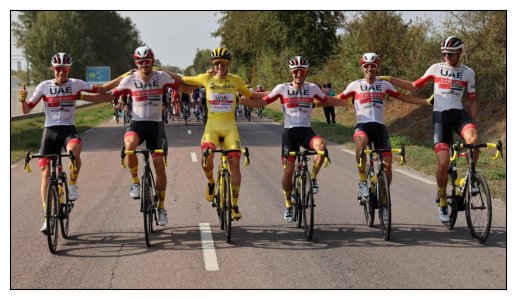

In [32]:
from urllib.request import urlopen
from urllib.error import URLError
import matplotlib.pyplot as plt

#image_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/team_1.png?raw=true'
image_url = 'https://imgresizer.eurosport.com/unsafe/2560x0/filters:format(jpeg)/origin-imgresizer.eurosport.com/2022/06/27/3399674-69473648-2560-1440.jpg'

try:
    with Image.open(urlopen(image_url)) as im:
        # The following fixes some problems when loading images:
        # https://stackoverflow.com/a/64598016
        image = im.convert("RGB")
except (URLError, OSError):
    print("please provide a valid URL or local path")
else:    
    print(f"{image.mode} image of size {image.size}")
    plt.imshow(np.asarray(image))
    plt.xticks([])
    plt.yticks([])
    plt.show()

Preprocess image

In [33]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [34]:
tensor = preprocess(image)

In [35]:
prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True)

## Load pre-trained model

In [36]:
model = models.resnet18(pretrained=True)

In [55]:
model.eval();

In [38]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [39]:
final_layer = model._modules.get('layer4')

In [40]:
activated_features = SaveFeatures(final_layer)

In [41]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

/var/folders/gz/cp34mcp54pn6gmdlbwkdhdwh0000gn/T/ipykernel_10339/3865586587.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


In [42]:
topk(pred_probabilities,1)

torch.return_types.topk(
values=tensor([0.8849]),
indices=tensor([880]))

In [43]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [54]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [46]:
class_idx = topk(pred_probabilities,1)[1].int()
class_idx

tensor([880], dtype=torch.int32)

## Prediction

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

Animal team: 354: 'Arabian camel, dromedary, Camelus dromedarius'

TdF team: 880: 'unicycle, monocycle'

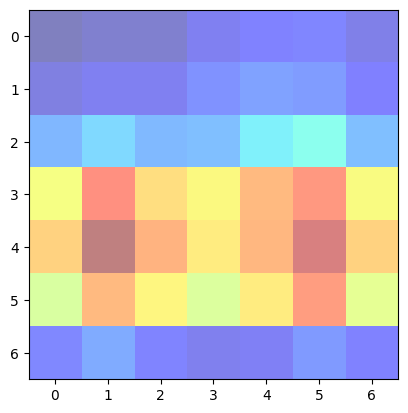

In [47]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )
imshow(overlay[0], alpha=0.5, cmap='jet')

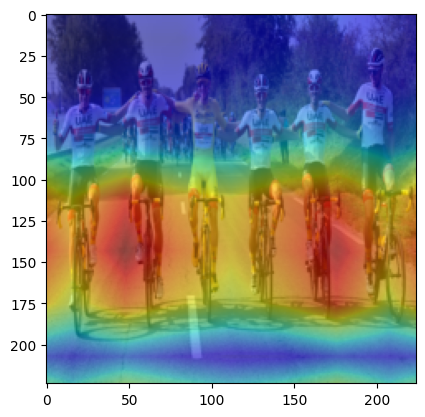

In [48]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

## Prediction second choice

Picking the second best prediction

Animal team: 643: 'mask'

TdF team 439: 'bearskin, busby, shako',

In [49]:
class_idx = topk(pred_probabilities,2)[1].int()
class_idx

tensor([880, 439], dtype=torch.int32)

In [52]:
overlay = getCAM(activated_features.features, weight_softmax, 439 )

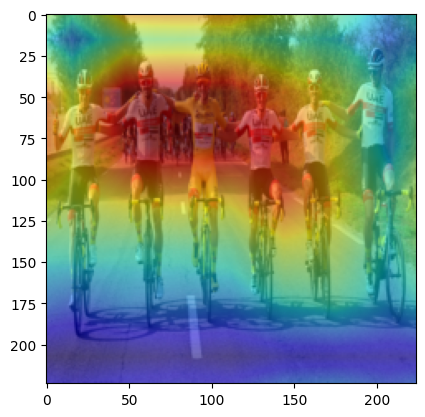

In [53]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');
